In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

In [3]:
import os

DATASET_PATH = r"C:\Users\lakshmilokeswari\Downloads\archive (1)\total"

# Get class names
classes = sorted(os.listdir(DATASET_PATH))

print("Detected Classes:")
for i, cls in enumerate(classes):
    print(f"{i} → {cls}")


Detected Classes:
0 → glioma
1 → meningioma
2 → notumor
3 → pituitary


In [4]:
from collections import Counter

image_count = {}

for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    image_count[cls] = len(os.listdir(cls_path))

print("Image count per class:")
for k, v in image_count.items():
    print(f"{k}: {v}")


Image count per class:
glioma: 500
meningioma: 500
notumor: 500
pituitary: 500


In [5]:
total_images = sum(image_count.values())
print("Total images in dataset:", total_images)


Total images in dataset: 2000


In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm

DATASET_PATH = r"C:\Users\lakshmilokeswari\Downloads\archive (1)\total"

X = []
y = []

IMAGE_SIZE = 64  # 64x64

classes = sorted(os.listdir(DATASET_PATH))
print("Classes:", classes)

for label in classes:
    class_path = os.path.join(DATASET_PATH, label)
    
    for img_name in tqdm(os.listdir(class_path), desc=f"Loading {label}"):
        img_path = os.path.join(class_path, img_name)

        image = cv2.imread(img_path)

        # Skip broken images
        if image is None:
            continue

        # ✅ BGR → GRAYSCALE
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # ✅ Resize
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        # ✅ Normalize
        image = image.astype("float32") / 255.0

        # ✅ Flatten → 4096 features
        image = image.flatten()

        X.append(image)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


Loading pituitary: 100%|█████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.52it/s]

X shape: (2000, 4096)
y shape: (2000,)


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Label mapping:")
for cls, idx in zip(le.classes_, le.transform(le.classes_)):
    print(f"{cls} → {idx}")


Label mapping:
glioma → 0
meningioma → 1
notumor → 2
pituitary → 3


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape :", X_test.shape, y_test.shape)



Train shape: (1600, 4096) (1600,)
Test shape : (400, 4096) (400,)


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


In [19]:
dt_pipeline = Pipeline([
    ("dt", DecisionTreeClassifier(random_state=42))
])


In [25]:
param_grid_dt = {
    "dt__max_depth": [3, 4, 5, 6],              # VERY shallow
    "dt__min_samples_split": [50, 75, 100],     # large splits
    "dt__min_samples_leaf": [30, 50, 75],       # force generalization
    "dt__criterion": ["gini"]                   # entropy overfits more here
}


In [26]:
grid_dt = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=param_grid_dt,
    scoring="f1_macro",   # IMPORTANT for class balance
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__criterion': ['gini'],
                         'dt__max_depth': [3, 4, 5, 6],
                         'dt__min_samples_leaf': [30, 50, 75],
                         'dt__min_samples_split': [50, 75, 100]},
             scoring='f1_macro', verbose=1)

In [27]:
best_dt = grid_dt.best_estimator_

print("Best Decision Tree Parameters:")
print(grid_dt.best_params_)


Best Decision Tree Parameters:
{'dt__criterion': 'gini', 'dt__max_depth': 6, 'dt__min_samples_leaf': 30, 'dt__min_samples_split': 50}


In [28]:
y_pred_dt = best_dt.predict(X_test)

dt_test_accuracy = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Test Accuracy:", dt_test_accuracy)

print("\nDecision Tree Classification Report (TEST):")
print(classification_report(y_test, y_pred_dt))


Decision Tree Test Accuracy: 0.725

Decision Tree Classification Report (TEST):
              precision    recall  f1-score   support

           0       0.93      0.64      0.76       100
           1       0.55      0.71      0.62       100
           2       0.79      0.76      0.78       100
           3       0.74      0.79      0.76       100

    accuracy                           0.72       400
   macro avg       0.75      0.73      0.73       400
weighted avg       0.75      0.72      0.73       400



In [29]:
y_pred_dt_train = best_dt.predict(X_train)

dt_train_accuracy = accuracy_score(y_train, y_pred_dt_train)
print("Decision Tree Train Accuracy:", dt_train_accuracy)

print("\nDecision Tree Classification Report (TRAIN):")
print(classification_report(y_train, y_pred_dt_train))


Decision Tree Train Accuracy: 0.77375

Decision Tree Classification Report (TRAIN):
              precision    recall  f1-score   support

           0       0.94      0.69      0.80       400
           1       0.60      0.68      0.63       400
           2       0.85      0.88      0.86       400
           3       0.78      0.84      0.81       400

    accuracy                           0.77      1600
   macro avg       0.79      0.77      0.78      1600
weighted avg       0.79      0.77      0.78      1600



In [30]:
from collections import Counter

print("Train label distribution:", Counter(y_train))
print("Test label distribution:", Counter(y_test))


Train label distribution: Counter({np.int64(1): 400, np.int64(0): 400, np.int64(3): 400, np.int64(2): 400})
Test label distribution: Counter({np.int64(3): 100, np.int64(1): 100, np.int64(0): 100, np.int64(2): 100})


In [31]:
from collections import Counter

print("Predicted label distribution:", Counter(y_pred_dt))


Predicted label distribution: Counter({np.int64(1): 128, np.int64(3): 107, np.int64(2): 96, np.int64(0): 69})


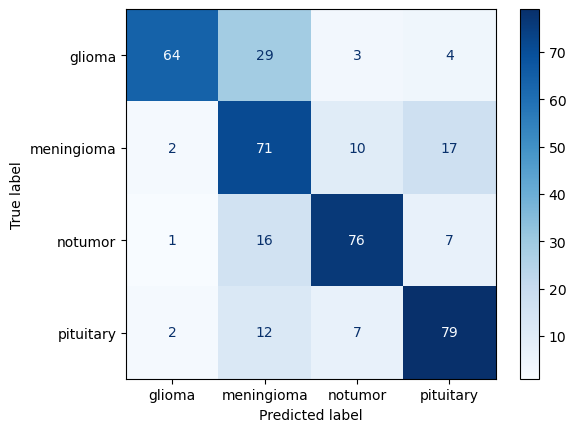

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.show()


In [35]:
import pickle

with open("final_dt_model_medical.pkl", "wb") as f:
    pickle.dump(best_dt, f)


In [34]:
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [36]:
sample = X_test[0].reshape(1, -1)
print("Model prediction:", le.inverse_transform(best_dt.predict(sample)))


Model prediction: ['pituitary']
